<a href="https://colab.research.google.com/github/ipietri/w266_Final_Project/blob/master/notebooks/RtGender-Notebooks/Greyscaling/RtGender_Sentiment_Greyscaling_Universal_Sentence_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

[link text](https://)# Universal Sentence Encoder


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Funiversal-sentence-encoder%2F4%20OR%20google%2Funiversal-sentence-encoder-large%2F5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


## Setup

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [ ]:
%%capture
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [ ]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Similarity

In [ ]:
train_df_aug = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_rtgender_train_data.csv')
#train_df_aug = train_df_aug[train_df_aug['id'] == 2129]
train_df_aug['text'] = train_df_aug['text'].apply(lambda x: x.split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_df_aug

,id,text,label,is_og,new_col
2256,2129,"[Making, America, great, again, -, America, 19...",0,0,NaN
2257,2129,"[Making, America, good, again, -, America, 192...",0,0,NaN
23118,2129,"[Making, America, great, again, -, America, 19...",0,1,defaultdict(<function locate_scale_word.<local...


In [ ]:
import math

# get each unique id and then cycle through
unique_id_list = train_df_aug['id'].unique().tolist()

# instantiate lists 
scores_list = []
cs_list = []
mean_list = []
og_sentence = []
augmented_sentence_list = []
id_list = []

# for every origin
for id in unique_id_list: 
  # subset the dataframe and separate original and augmented examples
  data = train_df_aug[train_df_aug['id'] == id]
  og = data[data['is_og'] == 1]
  og = og.iloc[0].text

  # return all augmented examples
  augmented = data[data['is_og'] == 0]
  # if there are no augmented examples add NA to list
  if len(augmented) == 0:
    id_list.append(id)
    scores_list.append(np.nan)
    cs_list.append(np.nan)
    mean_list.append(np.nan)
    og_sentence.append(og_list)
    augmented_sentence_list.append(np.nan)
    

  else: 
 
    # encode the original example
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(og)), axis=1)
    for i in range(len(augmented)):
      example = augmented.iloc[i].text
      # add the score for each augmented example to scores_list
      sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(example)), axis=1)
      
      cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
      clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
      scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi

      id_list.append(id)
      og_sentence.append(og)
      augmented_sentence_list.append(example)
      cs_list.extend(cosine_similarities)
      scores_list.extend(scores)
      
      mean_score = tf.reduce_mean(scores).numpy()
      mean_list.append(mean_score)


In [ ]:
df_with_scores = pd.DataFrame({'id':id_list, 'og_sentence':og_sentence, 
              'augmented_sentence':augmented_sentence_list,
              'mean_arc_sine_score': mean_list})

df_with_scores

In [ ]:
import pickle
with open('/content/drive/MyDrive/w266/universal_sentence_arc_df_rtgender.pkl', 'wb') as f:
  pickle.dump(df_with_scores, f)
 

Visualize distribution

In [ ]:
mean_arc_sine_score = df_with_scores['mean_arc_sine_score'].to_list()

[Text(0.5, 1.0, 'RtGender Mean Arc Sine Score')]

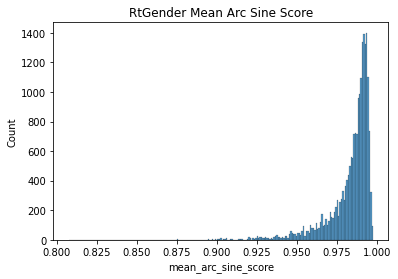

In [ ]:
sns.histplot(df_with_scores['mean_arc_sine_score']).set(title='RtGender Mean Arc Sine Score')

The data are not normally distributed. Approximately 25% of our examples have an arc sine of less than 0.98. 

In [ ]:
print("P10: ", np.nanquantile(mean_arc_sine_score, 0.1))
print("P25: ", np.nanquantile(mean_arc_sine_score, 0.25))
print("P50: ", np.nanquantile(mean_arc_sine_score, 0.5))
print("P75: ", np.nanquantile(mean_arc_sine_score, 0.75))
print("P90: ", np.nanquantile(mean_arc_sine_score, 0.9))

p25_threshold = np.nanquantile(mean_arc_sine_score, 0.25)

NameError: ignored

Low match examples

In [ ]:
# standard deviation ignoring NAs
np.nanstd(df_with_scores['mean_arc_sine_score'])

0.014958751524850038

In [ ]:
df_with_scores[df_with_scores['mean_arc_sine_score'] < .95]

,id,og_sentence,augmented_sentence,mean_arc_sine_score
12,6,"[Yay, for, useful,, practical, presi's!!, :D]","[Yay, for, useful,, possible, presi's!!, :D]",0.936462
13,6,"[Yay, for, useful,, practical, presi's!!, :D]","[Yay, for, useful,, realistic, presi's!!, :D]",0.942082
14,6,"[Yay, for, useful,, practical, presi's!!, :D]","[Yay, for, useful,, feasible, presi's!!, :D]",0.945742
44,43,"[Good, luck,Shelby!!!!]","[sufficient, luck,Shelby!!!!]",0.841531
45,43,"[Good, luck,Shelby!!!!]","[adequate, luck,Shelby!!!!]",0.846346
...,...,...,...,...
20742,20758,"[It, is, embarrassing, to, watch!]","[It, is, uncomfortable, to, watch!]",0.934567
20763,20783,"[It's, the, equal, work, that, is, the, problem.]","[It's, the, like, work, that, is, the, problem.]",0.948009
20793,20844,"[Easy, one., Murderous, FAILURE]","[Easy, one., violent, FAILURE]",0.919935
20845,20935,"[YOURE, NOT, MY, REAL, DAD!]","[YOURE, NOT, MY, good, DAD!]",0.923343


Strong Match Examples

In [ ]:
strong_matches = df_with_scores[df_with_scores['mean_arc_sine_score'] > .994]

In [ ]:
strong_matches[strong_matches['id'] == 521]

,id,og_sentence,augmented_sentence,mean_arc_sine_score
517,521,"[An, amazing, talk,, with, some, awesome, foot...","[An, amazing, talk,, with, some, good, footage...",0.994198
518,521,"[An, amazing, talk,, with, some, awesome, foot...","[An, amazing, talk,, with, some, great, footag...",0.995923
519,521,"[An, amazing, talk,, with, some, awesome, foot...","[An, amazing, talk,, with, some, wonderful, fo...",0.994175


In [ ]:
' '.join(strong_matches[strong_matches['id'] == 521]['og_sentence'].values[0])

'An amazing talk, with some awesome footage. I especially liked the two speakers in the film: the young girl made me feel humble, and the old man inspired me to take a step back and appreciate my luck.'

In [ ]:
' '.join(strong_matches[strong_matches['id'] == 521]['augmented_sentence'].values[0])

'An amazing talk, with some good footage. I especially liked the two speakers in the film: the young girl made me feel humble, and the old man inspired me to take a step back and appreciate my luck.'

# Pre-process 

In [ ]:
import pickle 
with open('/content/drive/MyDrive/w266/universal_sentence_arc_df_rtgender.pkl', 'rb') as handle:
    df_aug = pickle.load(handle)


In [ ]:
df_aug

,id,og_sentence,augmented_sentence,mean_arc_sine_score
0,0,"[Thank, you, Congresswoman, Bass., Keep, up, t...","[Thank, you, Congresswoman, Bass., Keep, up, t...",0.980176
1,5,"[I'm, looking, forward, to, seeing, some, *Goo...","[I'm, looking, forward, to, seeing, some, *Goo...",0.993922
2,5,"[I'm, looking, forward, to, seeing, some, *Goo...","[I'm, looking, forward, to, seeing, some, *Goo...",0.994353
3,5,"[I'm, looking, forward, to, seeing, some, *Goo...","[I'm, looking, forward, to, seeing, some, *Goo...",0.994471
4,5,"[I'm, looking, forward, to, seeing, some, *Goo...","[I'm, looking, forward, to, seeing, some, *Goo...",0.993862
...,...,...,...,...
35478,21179,"[many already had coverage, with doctors and p...",NaN,NaN
35479,21180,"[many already had coverage, with doctors and p...",NaN,NaN
35480,21181,"[many already had coverage, with doctors and p...",NaN,NaN
35481,21182,"[many already had coverage, with doctors and p...",NaN,NaN


Keep all original text plus all augmented examples that meet or exceed the 25th %tile

In [ ]:
# set threshold at P25 
p25_threshold = np.nanquantile(df_aug.mean_arc_sine_score, 0.25)
print("threshold for similarity: ", p25_threshold)

augmented_examples = df_aug[df_aug['mean_arc_sine_score']>= p25_threshold][['id', 'augmented_sentence']]
og_examples = df_aug[['id', 'og_sentence']]

augmented_examples.rename({'augmented_sentence': 'text'}, axis = 1, inplace = True)
og_examples.rename({'og_sentence': 'text'}, axis = 1, inplace = True)
og_examples = og_examples.drop_duplicates(subset = ['id'])
new_df = augmented_examples.append(og_examples)


threshold for similarity:  0.9802090525627136


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
len(new_df)

36927

In [ ]:
# add back the sentiment labels (match on id)
train_df_aug = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_rtgender_train_data.csv')
# get unique list of ids and labels
id_to_label_df = train_df_aug[['id','label']].drop_duplicates(subset = 'id')
len(id_to_label_df)


21184

In [ ]:
# join with the new_df it should not create any new records
new_df = pd.merge(new_df, id_to_label_df, on = 'id', how = 'inner')
len(new_df)

36927

In [ ]:
# save text as string not list
new_df['text'] = new_df['text'].apply(lambda x: ' '.join(x))

## Import Dev Data and Convert to HuggingFace friendly format

In [ ]:
train_df = new_df
dev_df = pd.read_csv('/content/drive/MyDrive/w266/annotations_dev.csv')
print('dev_shape: ',dev_df.shape)

# there are NaNs in the dev dataset remove 
nan_values = dev_df[dev_df.isna().any(axis=1)] 
print(nan_values)

# return without missing values in response_text
dev_df.dropna(subset = ["response_text"], inplace=True)

print("Train shape", train_df.shape)
print("Dev shape", dev_df.shape)

dev_shape:  (2303, 9)
      Unnamed: 0         source op_gender  ...   relevance label labels_4
830         2576  facebook_wiki         M  ...  Irrelevant     1        1
1664        2722  facebook_wiki         W  ...  Irrelevant     1        1

[2 rows x 9 columns]
Train shape (36927, 3)
Dev shape (2301, 9)


In [ ]:
# keep only a few columns and rename dev col names
dev_df = dev_df[['response_text', 'labels_4']]
dev_df.rename(columns = {'response_text':'text', 'labels_4': 'label'}, inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Huggingface friendly format

In [ ]:
%%capture
!pip install datasets
import datasets 
from datasets import load_dataset, Dataset, DatasetDict

In [ ]:
# change to dataset to work with Huggingface transformer & remove unused columns
columns_to_remove = ['id', '__index_level_0__']

train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

train_dataset = train_dataset.remove_columns(column_names= columns_to_remove)
dev_dataset = dev_dataset.remove_columns(column_names= '__index_level_0__')

# combine into a DataDictionary for huggingface use
rtg_dataset = DatasetDict({
    'train': train_dataset,
    'dev': dev_dataset 
})

rtg_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 36927
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 2301
    })
})

# Tokenize 

In [ ]:
%%capture
!pip install -q transformers
import transformers
import json
from tqdm import tqdm
#from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import logging
logging.basicConfig(level=logging.ERROR)

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
max_length = train_df['text'].astype(str).map(len).quantile(0.99).astype(int)
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length = int(max_length))

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

rtg_encoded = rtg_dataset.map(tokenize, batched=True, batch_size=None)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Model

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 4
epochs = 2
iterations = 5
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
rtg_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_weighted = f1_score(labels, preds, average="weighted")
    f1_macro = f1_score(labels, preds, average = 'macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1_weighted, "f1_macro": f1_macro} 

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(rtg_encoded["train"]) // batch_size*3
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                 # metric_for_best_model="f1_macro",
                                 # weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  save_strategy="steps",
                                  disable_tqdm=False
                                  )

In [ ]:
from sklearn.metrics import classification_report

accuracy_list = []
weighted_f1_score_list = []
macro_f1_score_list = []
negative_f1_score = []
neutral_f1_score = []
mixed_f1_score = []
positive_f1_score = []


for i in range(iterations):
  try:
    del trainer
    del results
    del cr
  except: pass


  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=rtg_encoded["train"],
                  eval_dataset=rtg_encoded["dev"])
  trainer.train()
  results = trainer.evaluate()

  # append macro metrics to lists
  accuracy_list.append(results.get('eval_accuracy'))
  weighted_f1_score_list.append(results.get("eval_f1"))
  macro_f1_score_list.append(results.get("eval_f1_macro"))

  trainer.predict(rtg_encoded["dev"])
  # append the class-level F1 scores
  outputs = trainer.predict(rtg_encoded["dev"])
  predictions = outputs.predictions.argmax(1)
  labels = rtg_encoded["dev"]['label']
  cr = classification_report(labels, predictions, digits=3, output_dict=True)
  negative_f1_score.append(cr.get('0').get("f1-score"))
  neutral_f1_score.append(cr.get('1').get("f1-score"))
  positive_f1_score.append(cr.get('2').get("f1-score"))
  mixed_f1_score.append(cr.get('3').get("f1-score"))


  print(f'---------------------------Iteration {i+1} Complete---------------------------\n')

Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,1.182000,1.066447,0.581486,0.602381,0.503095
1000,0.948600,1.144158,0.619296,0.629309,0.526953
1500,0.778400,1.309187,0.640156,0.639848,0.531961
2000,0.748800,1.334499,0.620600,0.628032,0.522516
2500,0.676700,1.385954,0.631465,0.617752,0.509887
3000,0.681400,1.602950,0.631030,0.627745,0.514421
3500,0.656500,1.598125,0.633638,0.631906,0.525265
4000,0.651700,1.707475,0.634072,0.630483,0.522140
4500,0.595100,1.777380,0.644502,0.630631,0.521794
5000,0.573600,1.824602,0.643199,0.629032,0.514241


---------------------------Iteration 1 Complete---------------------------



Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.762800,1.478230,0.601478,0.620179,0.518951
1000,0.855800,1.336120,0.632334,0.629341,0.526721
1500,0.726300,1.458449,0.641895,0.637253,0.527437
2000,0.721600,1.435099,0.627988,0.631039,0.521101
2500,0.656400,1.597193,0.631030,0.622053,0.514591
3000,0.666600,1.545870,0.650587,0.641014,0.530241
3500,0.654300,1.628260,0.646241,0.633961,0.525158
4000,0.644000,1.680599,0.631030,0.630398,0.523818
4500,0.598700,1.668104,0.638418,0.624354,0.517923
5000,0.570400,1.766598,0.641026,0.638179,0.533791


---------------------------Iteration 2 Complete---------------------------



Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.584300,1.898494,0.617558,0.608244,0.502028
1000,0.640500,1.992212,0.602347,0.607329,0.505215
1500,0.734600,1.552328,0.627553,0.634859,0.532879
2000,0.704400,1.341372,0.641460,0.630334,0.514820
2500,0.633100,1.532229,0.637983,0.610404,0.500568
3000,0.664900,1.718562,0.630595,0.627226,0.518862
3500,0.644300,1.632210,0.642329,0.634446,0.523307
4000,0.634400,1.744824,0.646241,0.633297,0.516207
4500,0.574800,1.823766,0.648414,0.628609,0.511157
5000,0.559300,1.888456,0.644502,0.640307,0.533646


---------------------------Iteration 3 Complete---------------------------



Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.543400,2.137696,0.599305,0.580490,0.474544
1000,0.588400,2.122935,0.614515,0.613977,0.505684
1500,0.600100,2.094392,0.631030,0.627001,0.516004
2000,0.597200,2.043953,0.611908,0.597882,0.470792
2500,0.631800,1.674952,0.638853,0.610238,0.492703
3000,0.645900,1.837329,0.641026,0.636003,0.528891
3500,0.622300,1.778095,0.645806,0.629806,0.518213
4000,0.629100,1.887979,0.644068,0.639872,0.530895


Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.543400,2.137696,0.599305,0.580490,0.474544
1000,0.588400,2.122935,0.614515,0.613977,0.505684
1500,0.600100,2.094392,0.631030,0.627001,0.516004
2000,0.597200,2.043953,0.611908,0.597882,0.470792
2500,0.631800,1.674952,0.638853,0.610238,0.492703
3000,0.645900,1.837329,0.641026,0.636003,0.528891
3500,0.622300,1.778095,0.645806,0.629806,0.518213
4000,0.629100,1.887979,0.644068,0.639872,0.530895
4500,0.574900,1.983874,0.639287,0.616781,0.507475
5000,0.559700,2.057609,0.643633,0.641279,0.537318


---------------------------Iteration 4 Complete---------------------------



Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.538800,2.419709,0.629726,0.630418,0.518191
1000,0.577500,2.341078,0.612777,0.614265,0.507553
1500,0.555900,2.506796,0.637983,0.635091,0.527781
2000,0.560900,2.258612,0.646241,0.634344,0.517531
2500,0.565400,2.265933,0.629292,0.611778,0.505407
3000,0.654700,1.882582,0.636680,0.634863,0.525246
3500,0.629400,1.909578,0.643199,0.626718,0.508900
4000,0.621000,2.200521,0.631030,0.611773,0.495849
4500,0.566700,2.201623,0.642764,0.625770,0.513185
5000,0.554900,2.275127,0.634507,0.615031,0.504984


---------------------------Iteration 5 Complete---------------------------



# Evaluate BERT

In [ ]:
import statistics

print("%15s %s (%s)" % ("","Mean", "StDev"))

print("-"*29)
print("Macro Scores")
print("-"*29)

print(f"%15s %s (%s)" %("Accuracy",
    round(statistics.mean(accuracy_list),3),
    round(statistics.stdev(accuracy_list),3)))
print(f"%15s %5s (%s)" %("Macro F1",
    round(statistics.mean(macro_f1_score_list),3),
    round(statistics.stdev(macro_f1_score_list),3)))
print(f"%15s %5s (%s)" %("Weighted F1",
    round(statistics.mean(weighted_f1_score_list),3),
    round(statistics.stdev(weighted_f1_score_list),3)))

print("-"*29)
print("Class Scores")
print("-"*29)

print(f"%15s %s (%s)" %("Positive",
    round(statistics.mean(positive_f1_score),3),
    round(statistics.stdev(positive_f1_score),3)))
print(f"%15s %5s (%s)" %("Neutral",
    round(statistics.mean(neutral_f1_score),3),
    round(statistics.stdev(neutral_f1_score),3)))
print(f"%15s %5s (%s)" %("Negative",
    round(statistics.mean(negative_f1_score),3),
    round(statistics.stdev(negative_f1_score),3)))
print(f"%15s %5s (%s)" %("Mixed",
    round(statistics.mean(mixed_f1_score),3),
    round(statistics.stdev(mixed_f1_score),3)))

                Mean (StDev)
-----------------------------
Macro Scores
-----------------------------
       Accuracy 0.626 (0.025)
       Macro F1 0.513 (0.015)
    Weighted F1 0.621 (0.014)
-----------------------------
Class Scores
-----------------------------
       Positive 0.8 (0.007)
        Neutral 0.495 (0.055)
       Negative 0.533 (0.03)
          Mixed 0.221 (0.063)


# Parking Lot

## Similarity Visualized - Toy Example
Here we show the similarity in a heat map.


In [ ]:
toy = train_df_aug[train_df_aug['id'] == 21166]
print(len(toy))
toy['new_col']

5


21166    defaultdict(<function locate_scale_word.<local...
41982                                                  NaN
41983                                                  NaN
41984                                                  NaN
41985                                                  NaN
Name: new_col, dtype: object

In [ ]:
import pandas
import scipy
import math
import csv
import torch

og = toy[toy['is_og'] == 1].response_text.values[0]
og_list = og.split()
# encode the original example
sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(og_list)), axis=1)

augmented = toy[toy['is_og'] == 0]

toy_scores_list = []
toy_cs = []  
mean_list = []

for i in range(len(augmented)):
  
  # add the score for each augmented example to scores_list
  example = augmented.iloc[i]['response_text']
  example_list = example.split()
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(example_list)), axis=1)
  
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)

  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  mean_list.append(1-tf.reduce_mean(scores))



### Download data

In [ ]:
import pandas
import scipy
import math
import csv

sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True)
sts_dev = pandas.read_table(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
    os.path.join(
        os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

425984/409630 [===============================] - 1s 2us/step


In [ ]:
sts_dev.iloc[1]['sent_1']#.tolist()

'A young child is riding a horse.'

### Evaluate Sentence Embeddings

In [ ]:
sts_data = sts_test #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  """Returns the similarity scores"""
  return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
  scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

NameError: ignored

In [ ]:
og = data[data['is_og'] == 1]
og = og.iloc[0].text
sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(og)), axis=1)
print(sts_encode1)
augmented = data[data['is_og'] == 0]
example = augmented.iloc[0].text
sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(example)), axis=1)

for idx, (first, second) in enumerate(zip(og, example)):
  if first != second:
      print(embed(og[idx]))
      print(embed(example[idx]))
idx

tf.Tensor(
[[-0.07208054 -0.05960576  0.01701426 ... -0.06035902  0.07123204
  -0.04321669]
 [-0.06350074 -0.068571   -0.00219559 ... -0.03158493  0.01368519
  -0.00279464]
 [-0.05159458 -0.05047806 -0.00047816 ... -0.04386274 -0.01560179
  -0.02179034]
 ...
 [ 0.0218339  -0.02081991  0.02178606 ... -0.03176646 -0.0730495
  -0.0834123 ]
 [-0.08172479 -0.08214227  0.03475859 ... -0.03900565  0.01594186
  -0.03849058]
 [-0.06608716  0.03668152 -0.02736849 ... -0.07253785  0.03553044
   0.05273506]], shape=(31, 512), dtype=float32)


InvalidArgumentError: ignored

In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)